### Historical Simulation

In [5]:
import numpy as np
import pandas as pd

np.random.seed(7)

tickers = ["AAA", "BBB", "CCC"]
n_days  = 260  # ~1년 영업일
dates   = pd.bdate_range("2024-01-02", periods=n_days, freq="B")

mu = np.array([0.08, 0.05, 0.12])
sigma = np.array([0.20, 0.15, 0.30]) 
dt = 1/252

rets = np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn(n_days, len(tickers)))
prices_close = pd.DataFrame(100 * rets.cumprod(axis=0), index=dates, columns=tickers)

overnight = np.exp(0.0002 + 0.01*np.random.randn(n_days, len(tickers))) 
prices_open = prices_close.shift(1) * overnight
prices_open.iloc[0] = prices_close.iloc[0] * (1 + 0.001) 

intraday = 0.01 * np.abs(np.random.randn(n_days, len(tickers)))
high = pd.DataFrame(np.maximum(prices_open.values, prices_close.values) * (1 + intraday), index=dates, columns=tickers)
low  = pd.DataFrame(np.minimum(prices_open.values, prices_close.values) * (1 - intraday), index=dates, columns=tickers)

open_df  = prices_open.astype(float)
close_df = prices_close.astype(float)
high_df  = high.astype(float)
low_df   = low.astype(float)

ohlc = {"open": open_df, "high": high_df, "low": low_df, "close": close_df}

### Rebalancing

In [ ]:
rebalance_dates = pd.date_range(dates[0], dates[-2], freq="BMS") 

def random_weights(n_assets, tilt=None):
    w = np.random.rand(n_assets)
    if tilt is not None:
        w = w * (1 + np.asarray(tilt))
    w = np.maximum(w, 0)
    return w / w.sum()

rows = []
for dt_reb in rebalance_dates:
    w = random_weights(len(tickers), tilt=[0.0, -0.2, 0.2])
    rows.append(pd.Series(w, index=tickers, name=dt_reb))
weights_df = pd.DataFrame(rows)
if len(weights_df) >= 3:
    weights_df.loc[weights_df.index[2], "BBB"] = 0.0
    weights_df.loc[weights_df.index[2]] /= weights_df.loc[weights_df.index[2]].sum()

### Run Historical Simulation

In [7]:
from quantifilib.backtest.historical_simulation import HistoricalSimulation

sim = HistoricalSimulation(
    data=None,
    ohlc=ohlc,                         # 평가: close, 체결: open
    valuation_field="close",
    execution_field="open",
    weights_df=weights_df,
    rebalance_dates=rebalance_dates,
    initial_value=1_000_000,
    normalize_weights=True,
    fill_method="ffill",
    use_next_open=True, # execution next open price
    slippage_bps=3, # 3bp slippage
    commission={"variable_bps": 5, "fixed": 0.5, "min_per_trade": 1.0},
    allow_partial_shares=False, # 정수(또는 lot) 체결
    min_lot=1, # 종목별 lot dict도 가능
    deposit_rate_annual=0.03, # cash yield rate 3%
    borrow_rate_annual=0.06  # minus cash (loan) yield -6%
).run()

res = sim.get_results()

print("=== Tail of portfolio value (index_series) ===")
print(res["index_series"].tail(), "\n")

print("=== Tail of cash balance (cash_series) ===")
print(res["cash_series"].tail(), "\n")

print("=== Head of trade_ledger ===")
print(res["trade_ledger"].head(), "\n")

print("=== Tail of trade_ledger ===")
print(res["trade_ledger"].tail(), "\n")

print("=== Sample logs ===")
print(res["logs"][:6])

=== Tail of portfolio value (index_series) ===
2024-12-24    786962.530748
2024-12-25    782568.179547
2024-12-26    781607.668471
2024-12-27    778786.016124
2024-12-30    784474.887894
Freq: B, dtype: float64 

=== Tail of cash balance (cash_series) ===
2024-12-24    45.114133
2024-12-25    45.119425
2024-12-26    45.124717
2024-12-27    45.130011
2024-12-30    45.135304
Freq: B, dtype: float64 

=== Head of trade_ledger ===
        date ticker  side  shares_delta  exec_price_eff       notional  \
0 2024-02-02    AAA   buy        3211.0       99.877992  320708.233340   
1 2024-02-02    BBB   buy        4633.0       91.818863  425396.791838   
2 2024-02-02    CCC   buy        2322.0      109.064023  253246.660648   
3 2024-03-04    AAA   buy        4482.0      102.666388  460150.753116   
4 2024-03-04    BBB  sell       -1897.0       94.902794  180030.599596   

   commission  
0  160.854117  
1  213.198396  
2  127.123330  
3  230.575377  
4   90.515300   

=== Tail of trade_ledger =

### Output

- Index Series

<Axes: >

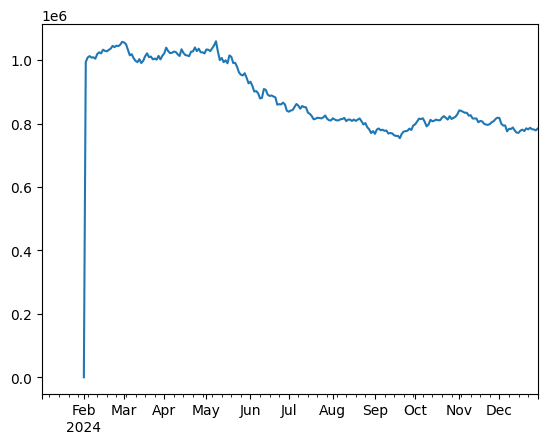

In [9]:
res['index_series'].plot()

현금 보유량

<Axes: >

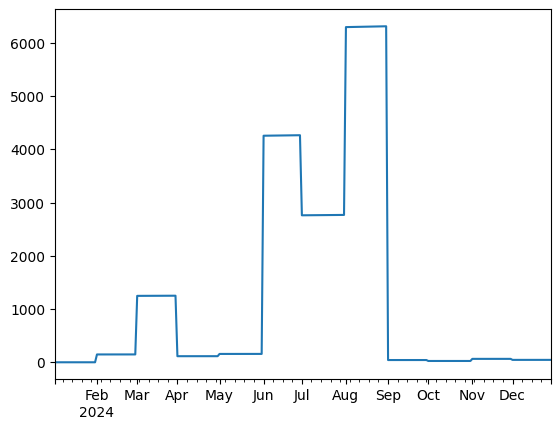

In [10]:
res['cash_series'].plot()

거래 장부
- 가중치, 체결가격 등의 거래시 가록된 데이터 장부


In [12]:
res['trade_ledger']

,date,ticker,side,shares_delta,exec_price_eff,notional,commission
0,2024-02-02,AAA,buy,3211.0,99.877992,320708.233340,160.854117
1,2024-02-02,BBB,buy,4633.0,91.818863,425396.791838,213.198396
2,2024-02-02,CCC,buy,2322.0,109.064023,253246.660648,127.123330
3,2024-03-04,AAA,buy,4482.0,102.666388,460150.753116,230.575377
4,2024-03-04,BBB,sell,-1897.0,94.902794,180030.599596,90.515300
5,2024-03-04,CCC,sell,-2276.0,123.762230,281682.835335,141.341418
6,2024-04-02,AAA,sell,-2865.0,100.468344,287841.805306,144.420903
7,2024-04-02,BBB,sell,-2736.0,88.918289,243280.438648,122.140219
8,2024-04-02,CCC,buy,4644.0,114.497448,531726.150648,266.363075
9,2024-05-02,AAA,sell,-3539.0,103.013543,364564.928559,182.782464


### Dollar Cost Averaging Simulation

월 적립식 투자 시뮬레이션, 단일 자산과 복수 자산에 대해 시뮬레이션 가능

In [1]:
import numpy as np
import pandas as pd

from quantifilib.data.data_loader.yfinance_loader import YahooFinanceLoader
from quantifilib.backtest.historical_simulation import DollarCostAveragingSimulation

loader = YahooFinanceLoader()
spy = loader.load(
    'SPY',
    start = '2020-01-01',
    interval = '1d',
    auto_adjust = False,
    multi_level_index = False,
    progress = False
)

In [3]:
px = spy["Close"].to_frame(name='SPY').dropna()
px.index = pd.to_datetime(px.index)  # ensure DatetimeIndex

val_px = px.copy()
exe_px = px.copy()

단일 자산에 대해서, 거래일을 지정

In [5]:
first_trading_days = (
    val_px.index.to_series()
    .groupby([val_px.index.year, val_px.index.month])
    .first()
    .values
)

In [6]:
contribution_amount = 100.0 # 월 100달러씩 적용
contrib = pd.Series(0.0, index=val_px.index) # 적립금 히스토리 생성
contrib.loc[first_trading_days] = contribution_amount

In [7]:
sim = DollarCostAveragingSimulation(
    val_px=val_px,
    exe_px=exe_px,
    initial_value=0.0,
    contribution_series=contrib, # Series with $100 on first trading day each month
    weights=None, # 단일 자산일 경우 None 혹은 'equal'로 지정
    allow_partial_shares=True, # fractional shares에 대해서 허용
    min_lot=1,
    use_next_open=False, # trade at same-day close; set True to use next available open
    deposit_rate_annual=0.0, # cash accrual (set if you want to model interest on cash)
    borrow_rate_annual=0.0,
    commission={"variable_bps": 0.0, "fixed": 0.0, "min_per_trade": 0.0},  # no fees by default
    cap_trade_pct=1.0,
    tick_size=None,
)

In [8]:
sim.run()

In [9]:
res = sim.get_results()

In [13]:
res.keys()

dict_keys(['index_series', 'cash_series', 'shares_record', 'trade_ledger', 'shares_ledger', 'logs'])

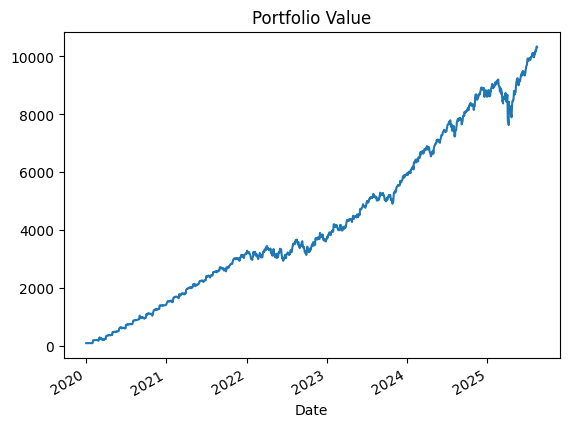

In [18]:
import matplotlib.pyplot as plt

res['index_series'].plot(title = 'Portfolio Value')
plt.show()

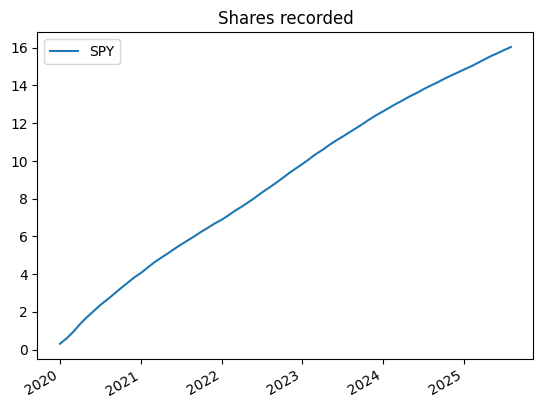

In [19]:
res['shares_record'].plot(title = 'Shares recorded')
plt.show()

In [20]:
res['trade_ledger']

,date,ticker,side,shares_delta,exec_price_eff,notional,commission
0,2020-01-02,SPY,buy,0.307815,324.869995,100.0,0.0
1,2020-02-03,SPY,buy,0.308528,324.119995,100.0,0.0
2,2020-03-02,SPY,buy,0.323530,309.089996,100.0,0.0
3,2020-04-01,SPY,buy,0.406256,246.149994,100.0,0.0
4,2020-05-01,SPY,buy,0.353619,282.790009,100.0,0.0
...,...,...,...,...,...,...,...
63,2025-04-01,SPY,buy,0.178263,560.969971,100.0,0.0
64,2025-05-01,SPY,buy,0.179061,558.469971,100.0,0.0
65,2025-06-02,SPY,buy,0.168717,592.710022,100.0,0.0
66,2025-07-01,SPY,buy,0.161904,617.650024,100.0,0.0


In [21]:
res['shares_ledger']

,date,ticker,price_ref,shares,amount
0,2020-01-02,SPY,324.869995,0.307815,100.000000
1,2020-02-03,SPY,324.119995,0.616343,199.769138
2,2020-03-02,SPY,309.089996,0.939874,290.505502
3,2020-04-01,SPY,246.149994,1.346130,331.349860
4,2020-05-01,SPY,282.790009,1.699749,480.672079
...,...,...,...,...,...
63,2025-04-01,SPY,560.969971,15.367169,8620.520336
64,2025-05-01,SPY,558.469971,15.546230,8682.102414
65,2025-06-02,SPY,592.710022,15.714946,9314.406114
66,2025-07-01,SPY,617.650024,15.876850,9806.336911


In [25]:
total_invested = float(contrib.sum())  # initial_value is 0 here

In [28]:
total_invested

6800.0

성과 (수익률)

In [29]:
mw_irr = sim.money_weighted_irr() # Money-weighted (IRR / XIRR)
twr = sim.time_weighted_return() # Time-weighted return
simple_ret = sim.simple_return_on_invested()

In [30]:
print(f"Simple return     : {simple_ret:,.2%}")
print(f"Time-weighted (TWR): {twr:,.2%}")
print(f"Money-weighted IRR : {mw_irr:,.2%}")

Simple return     : 51.75%
Time-weighted (TWR): 98.06%
Money-weighted IRR : 14.85%
